In [1]:
USER = 'Paolo'
LOSS = 'mean_squared_error'

In [2]:
import sys
import os
if colab := 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # BASE_PATH = '/content/drive/Shareddrives/Project_ML_23/' + USER + '/machine-learning-project'
    BASE_PATH = '/content/drive/My Drive/machine-learning-project'
    sys.path.insert(0, BASE_PATH)
    N_JOBS = -1
    sys.path.insert(0, BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'cup2023','ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'cup2023', 'neural_network')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'cup2023')
else :
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'neural_network')
    MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if colab := 'google.colab' in sys.modules:
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')
from keras import backend as K


from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2, set_random_state, mean_squared_error,save_optuna_study
from NN import NeuralNetwork
from joblib import dump

set_random_state(42)

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('neuralnetwork', NeuralNetwork(loss=LOSS, verbose=0))
])

In [8]:
param_grid = {
    'neuralnetwork__architecture': [
        (128, 64),
        (128, 128),
        (256, 128)
    ],
    'neuralnetwork__activation': ['relu'],
    'neuralnetwork__learning_rate': [1e-3, 1e-2],
    'neuralnetwork__momentum': [0.5,  1.0],
    'neuralnetwork__use_nesterov': [True, False],
    'neuralnetwork__weight_decay': [1e-3, 1e-2],
    'neuralnetwork__input_dimension': [10],
    'neuralnetwork__output_dimension': [3],
    'neuralnetwork__dropout_input_rate': [0.0, 0.1],
    'neuralnetwork__dropout_hidden_rate': [
        (0.1, 0.1),
        (0.2, 0.2)
    ],
    'neuralnetwork__patience': [9],
    'neuralnetwork__epochs': [50, 100, 150],
    'neuralnetwork__batch_size': [16, 32],
    'neuralnetwork__early' : [False]
}

In [9]:
from sklearn.metrics import make_scorer

mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
multidim_r2_scorer = make_scorer(multidim_r2, greater_is_better=True)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

scoring = {'MEE': mee_scorer, 'R2': multidim_r2_scorer, 'RMSE': rmse_scorer, 'MSE': mse_scorer}

In [10]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='MEE',
    n_jobs=N_JOBS,
    verbose=0
)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-2.47817076 -3.88090884 -2.62368117 ...         nan         nan
         nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.98965218 0.97366963 0.98908218 ...        nan        nan        nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-1.71215306 -2.57522147 -1.82267304 ...         nan         nan
         nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/mod

0epoch [00:00, ?epoch/s]

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('neuralnetwork',
                                        NeuralNetwork(verbose=0))]),
             n_jobs=-1,
             param_grid={'neuralnetwork__activation': ['relu'],
                         'neuralnetwork__architecture': [(128, 64), (128, 128),
                                                         (256, 128)],
                         'neuralnetwork__batch_size': [16, 32],
                         'neuralnetwork__dropout_hidden_rat...
                         'neuralnetwork__patience': [9],
                         'neuralnetwork__use_nesterov': [True, False],
                         'neuralnetwork__weight_decay': [0.001, 0.01]},
             refit='MEE',
             scoring={'MEE': make_scorer(mean_euclidean_error, greater_is_better=False),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False),
                      'R2': make_scorer(multidim_r2),
                      'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False)})

In [11]:
results = grid_search.cv_results_

results_df = pd.DataFrame(results)
csv_filename_result =os.path.join(MODEL_FOLDER, 'NN_Cup_Grid_Results.csv')
csv_filename_loss = os.path.join(MODEL_FOLDER, 'NN_Cup_Grid_Loss.csv')
results_df.to_csv(csv_filename_result, index=False)

In [22]:
best_params = grid_search.best_params_
best_index = grid_search.best_index_

mee = grid_search.best_score_
r2 = grid_search.cv_results_['mean_test_R2'][best_index]
rmse = grid_search.cv_results_['mean_test_RMSE'][best_index]
mse = grid_search.cv_results_['mean_test_MSE'][best_index]

print('Best parameters:', best_params)
print('Best MEE score:', abs(mee))
print('R2:', abs(r2))
print('RMSE:', abs(rmse))
print('MSE:', abs(mse))

Best parameters: {'neuralnetwork__activation': 'relu', 'neuralnetwork__architecture': (256, 128), 'neuralnetwork__batch_size': 16, 'neuralnetwork__dropout_hidden_rate': (0.1, 0.1), 'neuralnetwork__dropout_input_rate': 0.0, 'neuralnetwork__early': False, 'neuralnetwork__epochs': 150, 'neuralnetwork__input_dimension': 10, 'neuralnetwork__learning_rate': 0.01, 'neuralnetwork__momentum': 0.5, 'neuralnetwork__output_dimension': 3, 'neuralnetwork__patience': 9, 'neuralnetwork__use_nesterov': False, 'neuralnetwork__weight_decay': 0.01}
Best MEE score: 1.662657998813795
R2: 0.9952363348677162
RMSE: 1.2046300705439819
MSE: 1.479628466645976


# Learning Curve

In [13]:
train_scores = []

best_params = grid_search.best_params_

params = {
    'architecture': best_params['neuralnetwork__architecture'],
    'activation': best_params['neuralnetwork__activation'],
    'learning_rate': best_params['neuralnetwork__learning_rate'],
    'momentum': best_params['neuralnetwork__momentum'],
    'use_nesterov': best_params['neuralnetwork__use_nesterov'],
    'weight_decay': best_params['neuralnetwork__weight_decay'],
    'input_dimension': best_params['neuralnetwork__input_dimension'],
    'output_dimension': best_params['neuralnetwork__output_dimension'],
    'dropout_input_rate': best_params['neuralnetwork__dropout_input_rate'],
    'dropout_hidden_rate': best_params['neuralnetwork__dropout_hidden_rate'],
    'patience': best_params['neuralnetwork__patience'],
    'epochs': 800,
    'batch_size': best_params['neuralnetwork__batch_size'],
    'early': True
}

In [14]:
# Cross-validation with the best parameters
i = 0
final_model = []

for train_index, test_index in cv.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    i = i + 1

    # Generate 5 possible splits and foreach save a model and history
    pipeline_ = Pipeline([
        ('scaler', RobustScaler()),
        ('neuralnetwork', NeuralNetwork(verbose=0, **params, loss=LOSS, validation_data=(X_test_1, y_test_1)))
    ])

    # Save different model for each fold to make ensemble model later
    final_model.append(pipeline_.fit(X_train_1, y_train_1))
    train_scores.append(pipeline_.named_steps['neuralnetwork'].history.history)

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

In [15]:
train_scores_df = pd.DataFrame(train_scores)
train_scores_df.to_csv(csv_filename_loss, index=False)

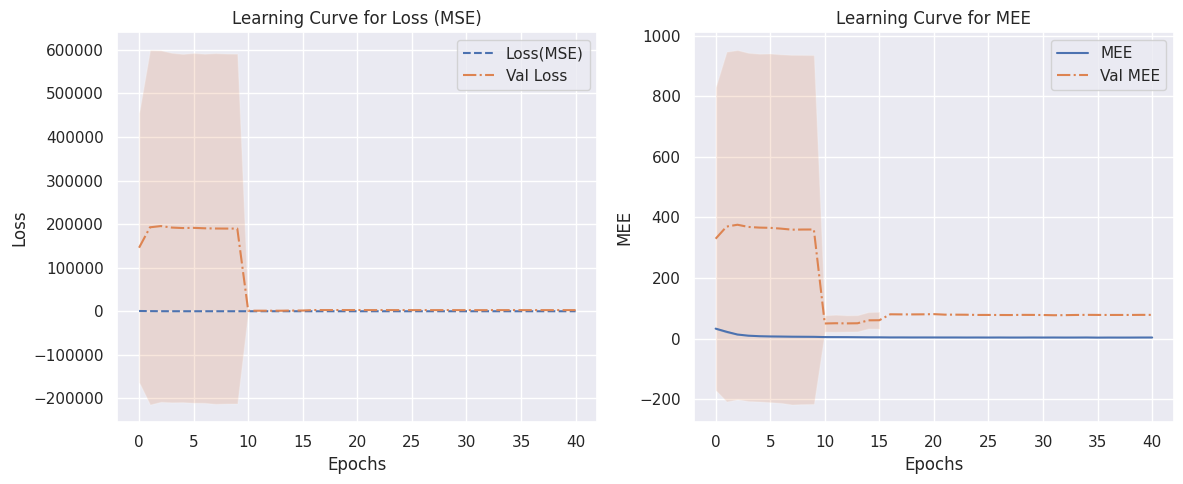

In [16]:
loss, val_loss, mee, val_mee = [], [], [], []

for i in range(len(train_scores_df)):
    loss.append(train_scores_df.iloc[i]['loss'])
    val_loss.append(train_scores_df.iloc[i]['val_loss'])
    mee.append(train_scores_df.iloc[i]['mean_euclidean_error'])
    val_mee.append(train_scores_df.iloc[i]['val_mean_euclidean_error'])

df_loss = pd.DataFrame(loss).T
df_val_loss = pd.DataFrame(val_loss).T
df_mee = pd.DataFrame(mee).T
df_val_mee = pd.DataFrame(val_mee).T

mean_loss = df_loss.mean(axis=1)
stdev_loss = df_loss.std(axis=1)
mean_val_loss = df_val_loss.mean(axis=1)
stdev_val_loss = df_val_loss.std(axis=1)

mean_mee = df_mee.mean(axis=1)
stdev_mee = df_mee.std(axis=1)
mean_val_mee = df_val_mee.mean(axis=1)
stdev_val_mee = df_val_mee.std(axis=1)

plt.figure(figsize=(12, 5))

# loss and val_loss
plt.subplot(1, 2, 1)
plt.plot(mean_loss, label='Loss(MSE)', linestyle='--')
plt.fill_between(range(len(mean_loss)), mean_loss-stdev_loss, mean_loss+stdev_loss, alpha=0.2)
plt.plot(mean_val_loss, label='Val Loss', linestyle='-.')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss-stdev_val_loss, mean_val_loss+stdev_val_loss, alpha=0.2)
plt.title('Learning Curve for Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# mee and val mee
plt.subplot(1, 2, 2)
plt.plot(mean_mee, label='MEE', linestyle='-')
plt.fill_between(range(len(mean_mee)), mean_mee-stdev_mee, mean_mee+stdev_mee, alpha=0.2)
plt.plot(mean_val_mee, label='Val MEE', linestyle='-.')
plt.fill_between(range(len(mean_val_mee)), mean_val_mee-stdev_val_mee, mean_val_mee+stdev_val_mee, alpha=0.2)
plt.title('Learning Curve for MEE')
plt.xlabel('Epochs')
plt.ylabel('MEE')
plt.legend()

plt.tight_layout()
save_plot(plt, IMAGES_FOLDER, 'learning_curve_nn_cup_grid')
plt.show()

# Test of the model

In [17]:
y_pred_ensemble = np.zeros_like(y_test)

for model in final_model:
    y_pred = model.predict(X_test)
    y_pred_ensemble += y_pred

y_pred_ensemble /= len(final_model)

mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = multidim_r2(y_test, y_pred_ensemble)
rmse_ensemble = root_mean_squared_error(y_test, y_pred_ensemble)
mee_ensemble = mean_euclidean_error(y_test, y_pred_ensemble)

print('Ensemble MSE:', mse_ensemble)
print('Ensemble R2:', r2_ensemble)
print('Ensemble RMSE:', rmse_ensemble)
print('Ensemble MEE:', mee_ensemble)

7/7 [==============================] - 0s 3ms/step
Ensemble MSE: 3.6296261701349657
Ensemble R2: 0.9857075790281268
Ensemble RMSE: 1.9051577809029272
Ensemble MEE: 2.622622049939031


In [23]:
results = {
    'Metric': ['Ensemble MEE', 'Ensemble R2', 'Ensemble RMSE', 'Ensemble MSE'],
    'Value': [mee_ensemble, r2_ensemble, rmse_ensemble, mse_ensemble]
}

results_df = pd.DataFrame(results)

# Save the dataframe as an Excel file
excel_filename = os.path.join(MODEL_FOLDER, 'results_test_grid_nn.xlsx')
results_df.to_excel(excel_filename, index=False)

## Ensamble of the final model using the whole dataset

In [18]:
# Cross-validation with the best parameters
i = 0
final_model_ = []
test_scores = []
for train_index, test_index in cv.split(X):
    X_train_1, X_test_1 = X[train_index], X[test_index]
    y_train_1, y_test_1 = y[train_index], y[test_index]
    i = i + 1

    # Generate 5 possible splits and foreach save a model and history
    pipeline_test = Pipeline([
        ('scaler', RobustScaler()),
        ('neuralnetwork', NeuralNetwork(verbose=0, **params, loss=LOSS, validation_data=(X_test_1, y_test_1)))
    ])

    # Save different model for each fold to make ensemble model later
    final_model_.append(pipeline_test.fit(X_train_1, y_train_1))
    test_scores.append(pipeline_test.named_steps['neuralnetwork'].history.history)

test_scores_df = pd.DataFrame(test_scores)

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

# Save model

In [19]:
# Save the model best parameters
best_params = grid_search.best_params_
best_params_df = pd.DataFrame([best_params])

csv_filename = os.path.join(MODEL_FOLDER, 'best_params_Grid_NN.csv')
best_params_df.to_csv(csv_filename, index=False)

In [20]:
model_path = os.path.join(MODEL_FOLDER, 'NN_grid_model.joblib')
dump(final_model, model_path, compress=3)

model_path = os.path.join(MODEL_FOLDER, 'NN_grid_model_final.joblib')
dump(final_model, model_path, compress=3)

['/content/drive/My Drive/machine-learning-project/trained_models/cup2023/NN_grid_model_final.joblib']